# Homework Assignment  6

In [ ]:
!pip install kaggle gensim bertopic spaCy vaex nltk afinn textblob
!python -m spacy download en_core_web_lg
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 388.6 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 607.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 3.3 MB/s eta 0:00:0000:0100:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from textblob import TextBlob
from afinn import Afinn
import en_core_web_lg
from tqdm import tqdm
import pandas as pd
import numpy as np
import nltk
import vaex
import torch
import os


# install required nltk packages
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("movie_reviews")
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/guyarieli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/guyarieli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/guyarieli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/guyarieli/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /Users/guyarieli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import kagglehub

os.environ["KAGGLEHUB_CACHE"] = (
    "/Users/guyarieli/Documents/אוניברסיטה/כריית נתונים במאגרי מידע גדולים/עבודות"
)

path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Path to dataset files: /Users/guyarieli/Documents/אוניברסיטה/כריית נתונים במאגרי מידע גדולים/עבודות/datasets/snap/amazon-fine-food-reviews/versions/2


**Question 1:** Construct a sentiment classifier using 80% of the reviews in the [Amazon Fine Food Reviews dataset](https://www.kaggle.com/snap/amazon-fine-food-reviews).
The classifier needs to predict if a product got a one-star or a five-star review.
Evaluate the classifier using the rest of the data (30pt).


In [ ]:
v_df = vaex.read_csv(
    f"datasets/snap/amazon-fine-food-reviews/versions/2/Reviews.csv", convert=True
)
v_df.head()

#,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,'I have bought several of the Vitality canned do...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,'Product arrived labeled as Jumbo Salted Peanuts...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",'This is a confection that has been around a few...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,'If you are looking for the secret ingredient in...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,'Great taffy at a great price. There was a wide...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,'I got a wild hair for taffy and ordered this fi...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,'This saltwater taffy had great flavors and was ...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",'This taffy is so good. It is very soft and che...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,"""Right now I'm mostly just sprouting this so my ..."
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,'This is a very healthy dog food. Good for their...


In [43]:
NUM_OF_SAMPLES: int = int(1e4)
TEST_RATIO: float = 0.2


def label_to_sentiment(label: str) -> dict:
    return {"1": "Negative", "5": "Positive"}[str(label)]


def score_to_sentiment(score: int) -> str | float:
    if score == 5:
        return "Positive"
    elif score == 1:
        return "Negative"
    return np.nan

TF-IDF Accuracy: 0.8845


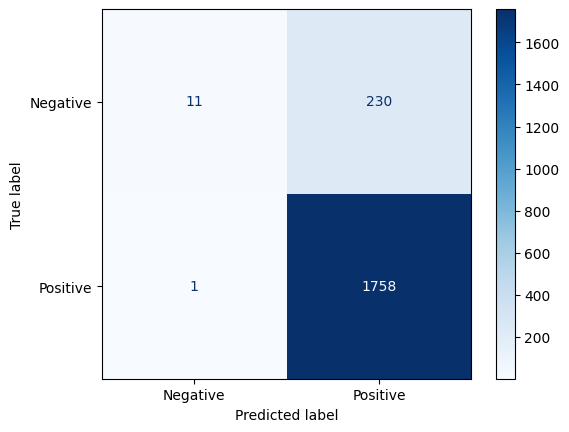

In [ ]:
df_with_selected_rating = v_df[(v_df.Score == 5) | (v_df.Score == 1)]
df_with_selected_rating = df_with_selected_rating.to_pandas_df().sample(
    NUM_OF_SAMPLES, random_state=42
)

df_with_selected_rating["Sentiment"] = df_with_selected_rating["Score"].apply(
    label_to_sentiment
)
df_with_selected_rating_with_text_and_sentiment = df_with_selected_rating[
    ["Text", "Sentiment"]
]

train, test = train_test_split(
    df_with_selected_rating_with_text_and_sentiment, test_size=TEST_RATIO
)

X_train, X_test = train["Text"], test["Text"]
y_train, y_test = train["Sentiment"], test["Sentiment"]

model = TfidfVectorizer(max_features=2000, stop_words="english")

X_train_tf_idf = model.fit_transform(X_train).toarray()
X_test_tf_idf = model.transform(X_test).toarray()

clf = RandomForestClassifier(max_depth=20, random_state=42, n_jobs=-1)
clf.fit(X_train_tf_idf, y_train)

y_predict = clf.predict(X_test_tf_idf)
accrucy_tf_idf = accuracy_score(y_test, y_predict)
print(f"TF-IDF Accuracy: {accrucy_tf_idf}")

cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

**Question 2:** Construct a sentiment classifier using features from the [TextBlob package](https://textblob.readthedocs.io/en/dev/index.html),
    and from the [affin package](https://pypi.org/project/afinn/). Compare the two classifiers results and visualize it (however you want) (20pt)

In [ ]:
def extract_subjectivity(t):
    return TextBlob(t).sentiment.subjectivity


def extract_polarity(t):
    return TextBlob(t).sentiment.polarity


def plot_matrix(y_predict, y_test, labels):
    cm = confusion_matrix(y_test, y_predict, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)

In [ ]:
afinn = Afinn()

X_train = X_train.to_frame()
X_test = X_test.to_frame()

X_train_tf_idf = pd.DataFrame(X_train_tf_idf)
X_train_tf_idf.columns = X_train_tf_idf.columns.astype(str)
X_test_tf_idf = pd.DataFrame(X_test_tf_idf)
X_test_tf_idf.columns = X_test_tf_idf.columns.astype(str)

X_train_tf_idf["afinn_score"] = X_train["Text"].apply(afinn.score).to_numpy()
X_test_tf_idf["afinn_score"] = X_test["Text"].apply(afinn.score).to_numpy()

X_train_tf_idf["text_blob_subjectivity"] = (
    X_train["Text"].apply(extract_subjectivity).to_numpy()
)
X_test_tf_idf["text_blob_subjectivity"] = (
    X_test["Text"].apply(extract_subjectivity).to_numpy()
)

X_train_tf_idf["text_blob_polarity"] = (
    X_train["Text"].apply(extract_polarity).to_numpy()
)
X_test_tf_idf["text_blob_polarity"] = X_test["Text"].apply(extract_polarity).to_numpy()

X_train_tf_idf.head()

,0,1,2,3,4,5,6,7,8,9,...,1993,1994,1995,1996,1997,1998,1999,afinn_score,text_blob_subjectivity,text_blob_polarity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.420833,0.237500
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.553333,0.725000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.661111,0.227778
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.516333,0.293667
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.365000,0.252500


Afinn Accuracy : 0.919


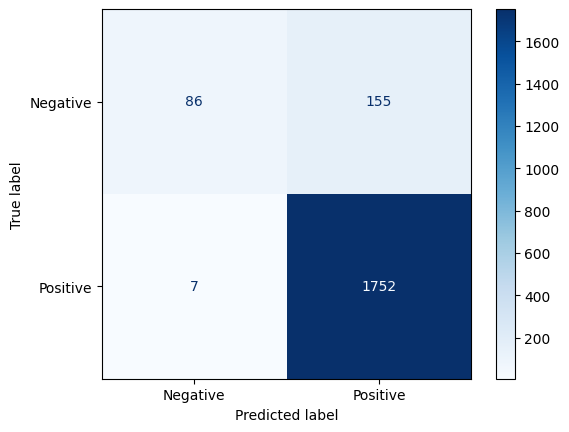

In [ ]:
clf = RandomForestClassifier()
clf.fit(
    X_train_tf_idf.drop(["text_blob_polarity", "text_blob_subjectivity"], axis=1),
    y_train,
)

y_predict = clf.predict(
    X_test_tf_idf.drop(["text_blob_polarity", "text_blob_subjectivity"], axis=1)
)

affin_acc = accuracy_score(y_test, y_predict)

print(f"Afinn Accuracy : {affin_acc}")


plot_matrix(y_predict, y_test, clf.classes_)

TextBlob Accuracy: 0.9225


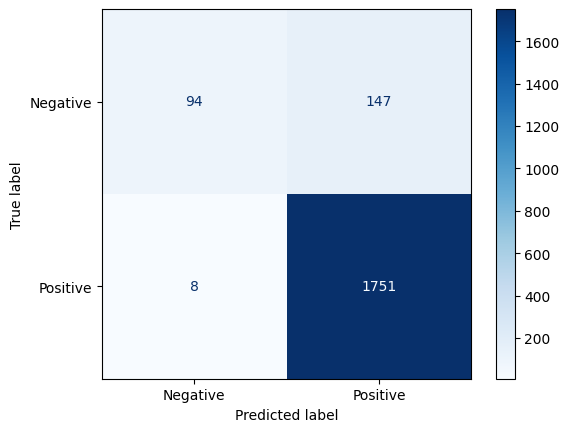

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train_tf_idf.drop(["afinn_score"], axis=1), y_train)

y_predict = clf.predict(X_test_tf_idf.drop(["afinn_score"], axis=1))


text_blob_acc = accuracy_score(y_test, y_predict)

print(f"TextBlob Accuracy: {text_blob_acc}")

plot_matrix(y_predict, y_test, clf.classes_)

**Question 3:**  Select a different reviews dataset and create a sentiment classifier which utilizes word embeddings (25pt).
Evaluate this classifier (5pt). Try to improve your classifier by adding additional features (20pt)

In [37]:
path = kagglehub.dataset_download("shivkumarganesh/tinder-google-play-store-review")

print("Path to dataset files:", path)

100%|██████████| 47.3M/47.3M [00:04<00:00, 12.1MB/s]

Extracting files...


Path to dataset files: /Users/guyarieli/Documents/אוניברסיטה/כריית נתונים במאגרי מידע גדולים/עבודות/datasets/shivkumarganesh/tinder-google-play-store-review/versions/171


In [44]:
def get_embeddings(text: str, tokinizer, model):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    tokens_tensor = torch.tensor(tokens).unsqueeze(0)

    outputs = model(tokens_tensor)

    last_hidden_state = outputs.last_hidden_state

    return last_hidden_state.squeeze(0).detach().numpy()

In [ ]:
nlp = en_core_web_lg.load()
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 13249/13249 [08:29<00:00, 26.03it/s]


Roberta Embed Accrucy: 0.9188679245283019


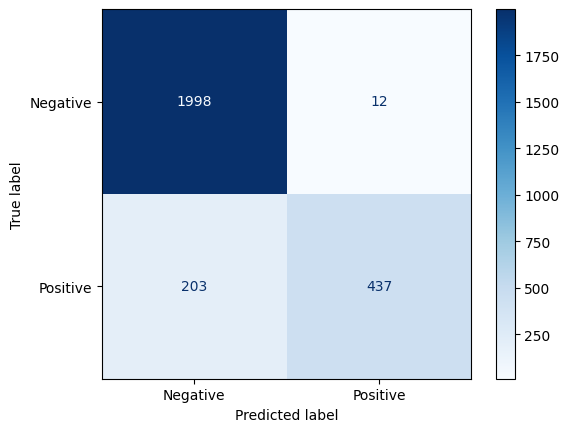

In [ ]:
df = pd.read_csv(
    "datasets/shivkumarganesh/tinder-google-play-store-review/versions/171/tinder_google_play_reviews.csv"
)
df["sentiment"] = df["score"].apply(score_to_sentiment)
df.dropna(inplace=True)
n_rows = int(1e4)

neg_df = df[df.sentiment == "Negative"]
pos_df = df[df.sentiment == "Positive"]
df = pd.concat([neg_df.head(n_rows), pos_df.head(n_rows)])


vectors_list = [
    get_embeddings(text, tokenizer, model)
    for text in tqdm(df["content"].apply(lambda t: t[:512]).values)
]

vectors_list_first_element = [v[0] for v in vectors_list]
cols = [f"BERT Feature {i}" for i in range(len(vectors_list_first_element[0]))]
roberta_df = pd.DataFrame(data=vectors_list_first_element, columns=cols)


X_train, X_test, y_train, y_test = train_test_split(
    roberta_df, df["sentiment"], test_size=TEST_RATIO, random_state=42
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

roberta_emb_acc = accuracy_score(y_test, y_predict)

print(f"Roberta Embed Accrucy: {roberta_emb_acc}")


plot_matrix(y_predict, y_test, clf.classes_)

100%|██████████| 13249/13249 [01:56<00:00, 113.29it/s]


Spacy Embed Accuracy: 0.9354716981132075


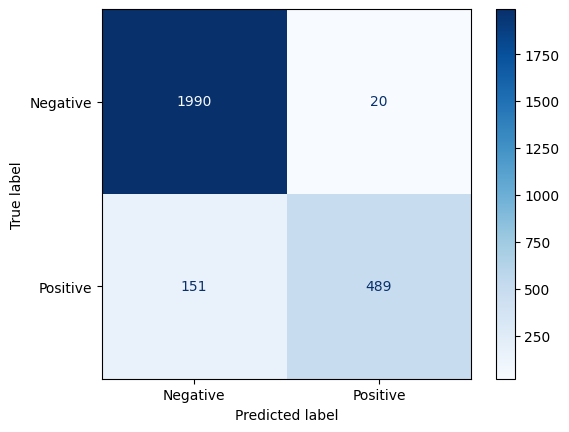

In [ ]:
vectors_list_nlp = [
    nlp(text).vector for text in tqdm(df["content"].apply(lambda t: t[:512]).values)
]
cols = [f"Spacy Feature {i}" for i in range(len(vectors_list_nlp[0]))]
spacey_df = pd.DataFrame(data=vectors_list_nlp, columns=cols)

X_train, X_test, y_train, y_test = train_test_split(
    spacey_df, df["sentiment"], test_size=TEST_RATIO, random_state=42
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

spacey_acc = accuracy_score(y_test, y_predict)

print(f"Spacy Embed Accuracy: {spacey_acc}")

plot_matrix(y_predict, y_test, clf.classes_)

Combine Accuracy of Roberta & spacy is: {spacy_and_roberta_acc}


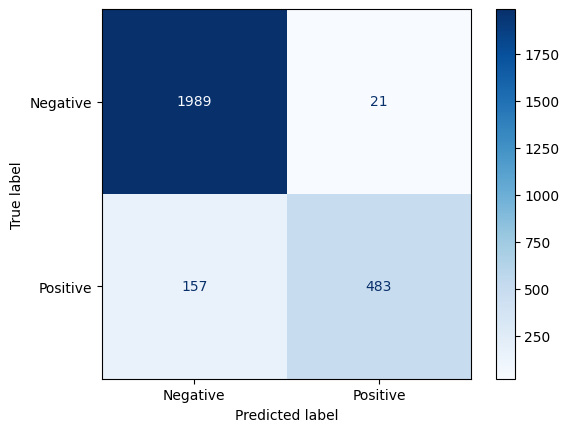

In [ ]:
combined_dataframe = pd.concat([roberta_df, spacey_df], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    combined_dataframe, df["sentiment"], test_size=TEST_RATIO, random_state=42
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

spacy_and_roberta_acc = accuracy_score(y_test, y_predict)

print("Combine Accuracy of Roberta & spacy is: {spacy_and_roberta_acc}")

plot_matrix(y_predict, y_test, clf.classes_)